<a href="https://colab.research.google.com/github/Oliz888/Awesome-LLM-in-Social-Science/blob/main/I590_LLMs_Lab_01_text_classification_for_students.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 1 - Text classification

Text classification is a fundamental task in natural language processing (NLP), where the goal is to assign a specific label or category to a given piece of text. It has diverse applications, including sentiment analysis, intent detection, entity extraction, and language identification.

In this lab, we will explore various approaches to leveraging language models for text classification. Specifically, you will learn how to:
* Utilize representation-based models for text classification
* Apply generative models for text classification


This lab is based on practice code from the book *Hands-on Large Language Models*. The code has been modified by Jisun An (jisunan@iu.edu).



#### **[Important]** Change Runtime Type to GPU

For this lab, you need to use "**GPU**." On the Menu, click "**Runtime**" --> "**Change Runtime Type**" and select Hardware Accelerator as "**T4 GPU**"!!

In [1]:
# Let's install the necessary libraries
!pip install datasets transformers sentence-transformers openai

## Data

The movie review dataset from Rotten Tomatoes, which includes approximately 10,000 critic reviews, will serve as our training and testing data. This widely-used collection will help us develop and assess our models' performance.


In [2]:
from datasets import load_dataset

# Load our data
data = load_dataset("rotten_tomatoes")
data

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train.parquet:   0%|          | 0.00/699k [00:00<?, ?B/s]

validation.parquet:   0%|          | 0.00/90.0k [00:00<?, ?B/s]

test.parquet:   0%|          | 0.00/92.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
})

In [3]:
data["train"][0, -1] #从训练集里取第 0 条和最后一条（-1）样本，快速看看文本和标签长什么样

{'text': ['the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .',
  'things really get weird , though not particularly scary : the movie is all portent and no content .'],
 'label': [1, 0]}

In [4]:
data["test"][0,1,-2,-1] #从测试集取第 0、1、倒数第 2、倒数第 1 条样本，进一步确认 test 集内容与标签格式

{'text': ['lovingly photographed in the manner of a golden book sprung to life , stuart little 2 manages sweetness largely without stickiness .',
  'consistently clever and suspenseful .',
  'the thing looks like a made-for-home-video quickie .',
  "enigma is well-made , but it's just too dry and too placid ."],
 'label': [1, 1, 0, 0]}

#### Practice 1.

Could you check the label distribution of the test set?


In [31]:
### Practice 1

from collections import Counter

label_dist = Counter(data["test"]["label"])
label_dist


Counter({1: 533, 0: 533})

## Evaluation

The sentiment analysis task uses binary classification, where:
* 0 indicates negative sentiment
* 1 indicates positive sentiment

To assess model performance, we'll calculate two key metrics using the predictions on our test dataset:
* Accuracy: Measures the overall proportion of correct predictions
* F1 Score: Provides a balanced measure of precision and recall, particularly useful for our binary classification task

Our evaluation function takes the model's predicted values and computes these metrics to gauge how well it performs on unseen movie reviews.



In [6]:
from sklearn.metrics import classification_report

def evaluate_performance(y_true, y_pred):  # 输入真实标签与预测标签
    """Create and print the classification report"""
    performance = classification_report(
        y_true, y_pred,
        target_names=["Negative Review", "Positive Review"]
    )
    print(performance)

def evaluate_performance_on_testset(y_pred):
    evaluate_performance(data["test"]["label"], y_pred)


We evaluate the test results using majority voting, where the final prediction is determined by selecting the most frequently occurring label among multiple model outputs. Since our data is balanced, we simply assign 1 (positive) as the majority vote.

The macro average calculates the unweighted mean of a metric (e.g., precision, recall, F1-score) across all classes, treating each class equally. The weighted average accounts for class imbalance by weighting each class's metric by its proportion of total instances, giving more influence to frequent classes.


In [7]:
y_pred = [1] * len(data["test"]) # 构造一个“很蠢但常见的基线”：对 test 的每条都预测为 1（positive）
evaluate_performance_on_testset(y_pred) # 用上面写的评估函数看这个 baseline 有多差（或在极端不平衡数据时有多“虚高”）

                 precision    recall  f1-score   support

Negative Review       0.00      0.00      0.00       533
Positive Review       0.50      1.00      0.67       533

       accuracy                           0.50      1066
      macro avg       0.25      0.50      0.33      1066
   weighted avg       0.25      0.50      0.33      1066



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Text Classification with Representation Models

Representation models transform raw data like text, images, or audio into structured numerical representations called embeddings. These embeddings capture meaningful patterns and relationships that make the data suitable for various machine learning tasks.

In this section, we will explore three approaches:
* **Classification with a task-specific model**: We'll use a BERT model that has been specifically trained for sentiment analysis, allowing it to directly classify text into sentiment categories.
* **Classification leveraging embeddings**:

    * **Supervised Classification with Sentence-BERT and Logistic Regression**: We'll convert texts into embeddings using Sentence-BERT, then train a logistic regression classifier on these embeddings for sentiment prediction.
    * **Classification by Leveraging Embedding Similarity**: We'll demonstrate how modern language models can classify text without any task-specific training, using only the semantic understanding encoded in their embeddings.



### Classification with a task-specific model

BERT, a well-known encoder-only architecture, has become a cornerstone for specialized NLP tasks. While generative models like GPT excel at broad language generation, encoder-only models like BERT are particularly effective for specific tasks and offer the advantage of being more compact.

For our sentiment analysis task, we'll use the [Twitter-RoBERTa-base for Sentiment Analysis](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest) model. This is a variant of BERT (specifically RoBERTa) that has been fine-tuned on Twitter data to specifically handle sentiment classification. RoBERTa builds on BERT's architecture with improved training methodologies, making it especially well-suited for sentiment analysis tasks.

Hugging Face's [pipeline()](https://huggingface.co/docs/transformers/en/main_classes/pipelines) provides an easy-to-use interface for running pre-trained NLP models on various tasks like text classification, sentiment analysis, summarization, and more. It automatically handles tokenization, model inference, and output processing, allowing users to apply state-of-the-art models with minimal code.

In [8]:
from transformers import pipeline # 导入 pipeline，它把“分词 + 模型推理 + 输出后处理”封装成一个可直接调用的对象

# Path to our HF model
model_path = "cardiffnlp/twitter-roberta-base-sentiment-latest" # 设置要用的 Hugging Face 模型名（这里是一个 RoBERTa sentiment 模型）
# Load model into pipeline
pipe = pipeline(
    model=model_path, # 加载该模型权重
    tokenizer=model_path, #用同名 tokenizer
    return_all_scores=True, #返回每个类别的分数（而不是只返回最高的那个）
    device="cuda:0" #用第 0 块 GPU（没 GPU 会报错/需要改成 cpu）
)


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cuda:0
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [9]:
# Let's check the output of this model
text = "I love this product! It's amazing." #准备一条明显正向的示例文本
result = pipe(text) #把文本丢给 pipe 推理，得到各类别分数

print(result) #打印结果，帮助你理解后面应该怎么抽取“负/正”分数

[[{'label': 'negative', 'score': 0.004995445720851421}, {'label': 'neutral', 'score': 0.007631378248333931}, {'label': 'positive', 'score': 0.9873731732368469}]]


In [10]:
import numpy as np
from tqdm import tqdm #导入 tqdm，显示进度条（跑 1000+ 条会更直观）
from transformers.pipelines.pt_utils import KeyDataset #让 pipeline 能从 dataset 的某个字段（这里是 "text") 流式读取，避免一次性塞爆内存。

# Run inference
y_pred = [] #初始化预测列表
for output in tqdm(pipe(KeyDataset(data["test"], "text")), total=len(data["test"])): #心循环：KeyDataset(data["test"], "text")：从 test 的 "text" 字段逐条取文本 pipe(...)：pipeline 会逐条推理 tqdm(..., total=...)：显示进度条并告诉它总条数
    negative_score = output[0]["score"] #从输出里取“第 0 类”的分数当作 negative（这里依赖该模型类别顺序）
    positive_score = output[2]["score"] #从输出里取“第 2 类”的分数当作 positive（同样依赖类别顺序）
    assignment = np.argmax([negative_score, positive_score]) #谁分高选谁 → 得到 0 或 1
    y_pred.append(assignment) #把这个 0/1 追加到预测列表


100%|██████████| 1066/1066 [00:24<00:00, 43.17it/s]


In [11]:
evaluate_performance_on_testset(y_pred) #用 test 真值标签评估你刚得到的 y_pred

                 precision    recall  f1-score   support

Negative Review       0.76      0.88      0.81       533
Positive Review       0.86      0.72      0.78       533

       accuracy                           0.80      1066
      macro avg       0.81      0.80      0.80      1066
   weighted avg       0.81      0.80      0.80      1066



### Classification leveraging embeddings:

Sometimes you might not find a pre-trained model that perfectly matches your specific task. While fine-tuning your own model is an option, it requires significant computational resources that aren't always available. This is where general-purpose embedding models provide a practical alternative.

These models can transform text into meaningful numerical representations (embeddings) that capture semantic information, allowing you to: 1) generate high-quality text representations; 2) use these embeddings with simpler, more resource-efficient machine learning models; and 3) achieve competitive results without the need for extensive model training.


#### Supervised Classification with Sentence-BERT and Logistic Regression

We can take a hybrid approach to classification by combining modern embedding models with traditional machine learning techniques. This two-step process involves:
* Using an embedding model to convert text into numerical features
* Training a classical classifier on these embeddings

For generating embeddings, we'll use [sentence-transformers/all-mpnet-base-v2](https://huggingface.co/sentence-transformers/all-mpnet-base-v2), which maps sentences & paragraphs to a 768 dimensional dense vector space and can be used for tasks like classification, clustering or semantic search. This model was selected based on its strong showing on the [MTEB](https://huggingface.co/spaces/mteb/leaderboard) leaderboard, which benchmarks models across various tasks.

This approach gives us more control over the training process while still leveraging the power of modern representation learning.

In [12]:
from sentence_transformers import SentenceTransformer #导入 SentenceTransformer，用于把句子/文本编码为 embedding 向量

# Load model
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2') #加载 all-mpnet-base-v2 作为 embedding 模型（输出 768 维向量）


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [13]:
from sklearn.metrics.pairwise import cosine_similarity #导入余弦相似度函数，计算向量之间的相似度

tmp_emb = model.encode(["I love an apple",  "I love an orange", "That is a cat"]) #把 3 句话编码成 3 个向量（shape 大概是 3×768）
cosine_similarity(tmp_emb) #计算这 3 个向量两两的余弦相似度，得到 3×3 的相似度矩阵，用来直观看“语义相近 → 相似度更高”

array([[0.99999994, 0.6487324 , 0.2482177 ],
       [0.6487324 , 1.0000001 , 0.13721108],
       [0.2482177 , 0.13721108, 0.9999995 ]], dtype=float32)

In [14]:
# Convert text to embeddings
train_embeddings = model.encode(data["train"]["text"], show_progress_bar=True)
test_embeddings = model.encode(data["test"]["text"], show_progress_bar=True)


Batches:   0%|          | 0/267 [00:00<?, ?it/s]

Batches:   0%|          | 0/34 [00:00<?, ?it/s]

In [15]:
train_embeddings.shape


(8530, 768)

In [16]:
from sklearn.linear_model import LogisticRegression

# Train a Logistic Regression on our train embeddings
clf = LogisticRegression(random_state=42)
clf.fit(train_embeddings, data["train"]["label"])

LogisticRegression(random_state=42)

In [17]:
# Predict previously unseen instances
y_pred = clf.predict(test_embeddings)
evaluate_performance_on_testset(y_pred)

                 precision    recall  f1-score   support

Negative Review       0.85      0.86      0.85       533
Positive Review       0.86      0.85      0.85       533

       accuracy                           0.85      1066
      macro avg       0.85      0.85      0.85      1066
   weighted avg       0.85      0.85      0.85      1066



#### Classification by Leveraging Embedding Similarity

What if we could classify text without training a classifier at all? We can achieve this through a simple but effective approach:

1. First, create representative embeddings for each class by averaging the embeddings of known examples (training data)

2. Then, for any new text:
    * Generate its embedding
    * Calculate its cosine similarity with each class's average embedding
    * Assign it to the class with the highest similarity



In [18]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import cosine_similarity

# Average the embeddings of all documents in each target label
df = pd.DataFrame(np.hstack([train_embeddings, np.array(data["train"]["label"]).reshape(-1, 1)]))
averaged_target_embeddings = df.groupby(768).mean().values

# Find the best matching embeddings between evaluation documents and target embeddings
sim_matrix = cosine_similarity(test_embeddings, averaged_target_embeddings)
y_pred = np.argmax(sim_matrix, axis=1)

# Evaluate the model
evaluate_performance(data["test"]["label"], y_pred)

                 precision    recall  f1-score   support

Negative Review       0.85      0.84      0.84       533
Positive Review       0.84      0.85      0.84       533

       accuracy                           0.84      1066
      macro avg       0.84      0.84      0.84      1066
   weighted avg       0.84      0.84      0.84      1066



#### Zero-shot Classification with Embeddings: Making Predictions Without Labeled Data

Obtaining labeled data for training can be expensive, time-consuming, and often requires significant human effort. Zero-shot classification offers a powerful alternative that can work with just the label names themselves, no training examples needed.

We can achieve this by:

1. First, create representative embeddings for each class by encoding the descriptions of the classes

2. Then, for any new text:
    * Generate its embedding
    * Calculate its cosine similarity with each class's embedding
    * Assign it to the class with the highest similarity


#### Practice 2.

Write a code to evaluate zero-shot classification with two labels: 'A negative review' and 'A positive review.'

What is the macro-average F1-score?

In [19]:
### Practice 2
from sklearn.metrics.pairwise import cosine_similarity

# Create embeddings for our labels
"YOUR CODE"

# Find the best matching label for each document
"YOUR CODE"

# Evaluate on the test set
"YOUR CODE"

'YOUR CODE'

#### Practice 3.

What happens when you use different label descriptions? Try using 'A very negative movie review' and 'A very positive movie review' and observe the results!

In [20]:
from sklearn.metrics.pairwise import cosine_similarity

# Create embeddings for our labels
"YOUR CODE"

# Find the best matching label for each document
"YOUR CODE"

# Evaluate on the test set
"YOUR CODE"

'YOUR CODE'

## Classification with Generative Models

Classification using generative language models, such as OpenAI's GPT models, differs from traditional classification approaches. Unlike task-specific models that directly output a class label, generative models take input text and generate output text, functioning as sequence-to-sequence models.

To achieve classification with these models, we must provide clear context and guide them toward the desired answers. This is primarily done through carefully crafted instructions, known as **prompts**. The process of iteratively refining prompts to achieve the desired output is called **prompt engineering**.

### Encoder-Decoder Models (Open Models)

A notable family of models built on the original transformer architecture (encoder-decoder model) is the Text-to-Text Transfer Transformer (T5), which treats every NLP task as a text-to-text problem.

T5 models undergo pretraining using a span-masked language modeling approach, where, instead of masking individual tokens (as seen in BERT), entire spans of tokens are masked, requiring the model to reconstruct them. This enhances the model's ability to understand context and semantics more effectively.

The fine-tuning phase is where T5 truly stands out. Rather than being fine-tuned for a single task, it reformulates all tasks—such as classification, translation, summarization, and question-answering—into a sequence-to-sequence format. This unified approach makes T5 highly adaptable and effective across a wide range of NLP applications.


In [21]:
# Load our model
# We now specify the 'task' since we are using a generative model.
pipe = pipeline(
    "text2text-generation",
    model="google/flan-t5-small",
    device="cuda:0"
)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0


In [22]:
output = pipe("Once upon a time,")
print(output)

[{'generated_text': 'he sat down and sat down and sat down.'}]


Compared to our task-specific model, we cannot simply provide the model with text and expect it to output the sentiment directly. Instead, we must explicitly instruct the model to perform sentiment analysis.

To achieve this, we prepend each document with the prompt: "Is the following sentence positive or negative?" This helps guide the model toward the intended task and ensures it generates a relevant response.

In [23]:
# Prepare our data
prompt = "Is the following sentence positive or negative? "
data = data.map(lambda example: {"t5": prompt + example['text']})
data

Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 't5'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label', 't5'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label', 't5'],
        num_rows: 1066
    })
})

In [24]:
data["train"][100]['t5']

'Is the following sentence positive or negative? chicago is sophisticated , brash , sardonic , completely joyful in its execution .'

In [25]:
pipe(data["train"][100]['t5'])

[{'generated_text': 'positive'}]

We can proceed with running the pipeline.

In [26]:
# Run inference
y_pred = []
for output in tqdm(pipe(KeyDataset(data["test"], "t5")), total=len(data["test"])):
    text = output[0]["generated_text"]
    y_pred.append(0 if text == "negative" else 1)

100%|██████████| 1066/1066 [01:01<00:00, 17.21it/s]


In [27]:
evaluate_performance_on_testset(y_pred)

                 precision    recall  f1-score   support

Negative Review       0.83      0.85      0.84       533
Positive Review       0.85      0.83      0.84       533

       accuracy                           0.84      1066
      macro avg       0.84      0.84      0.84      1066
   weighted avg       0.84      0.84      0.84      1066



### DeepSeek for Classification (Closed Models)

[OpenRouter.ai](https://openrouter.ai/) is a platform that provides access to a wide range of AI models, including both open-source and proprietary models, through a unified interface. It simplifies the process of discovering and utilizing large language models (LLMs).

Before running the classification example, you'll need to sign up and generate an API key at [OpenRouter.ai](https://openrouter.ai/).

**Note**: *OpenRouter.ai won't charge you until your usage exceeds $1!*


In [28]:
from tqdm import tqdm
from openai import OpenAI

client = OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key="YOUR_KEY"
)

There are many models available, but we will use [DeepSeek r1 distill LLaMA 70B](https://openrouter.ai/deepseek/deepseek-r1-distill-llama-70b), a cost-effective option for our task. It offers competitive performance while being affordable, priced at 0.23 USD per 1M input tokens and 0.69 USD per 1M output tokens.


Let's generate some text using the model. OpenRouter is compatible with OpenAI's API interface, allowing seamless integration with existing OpenAI SDK implementations.



In [29]:
my_model = "deepseek/deepseek-r1-distill-llama-70b"

completion = client.chat.completions.create(
  model=my_model,
  messages=[
    {
      "role": "user",
      "content": "What is the meaning of life?"
    }
  ]
)
print(completion.choices[0].message.content)

AuthenticationError: Error code: 401 - {'error': {'message': 'No cookie auth credentials found', 'code': 401}}

We define the chatgpt_generation function, which generates text based on a given prompt, input document, and the selected model.

When designing prompts, it's important to distinguish between user instructions and system-level guidance:
* System Prompt: Background instructions that define how the model should behave (e.g., "You are an AI assistant trained for sentiment analysis. Always provide concise and accurate responses.").

* User Prompt: The direct query or request given to the model, often phrased as a question or command (e.g., "Classify the sentiment of this review as positive or negative.").


In [ ]:
def chatgpt_generation(prompt, document, model):
    """Generate an output based on a prompt and an input document."""
    messages=[
        {
            "role": "system",
            "content": "You are a helpful assistant."
            },
        {
            "role": "user",
            "content":   prompt.replace("[DOCUMENT]", document)
            }
    ]
    chat_completion = client.chat.completions.create(
      messages=messages,
      model=model,
      temperature=0
    )
    return chat_completion.choices[0].message.content

Next, we need to create a template to instruct the model to perform classification.

This template is just an example and can be modified as needed. For now, we've kept it as simple as possible to demonstrate its usage.

In [ ]:
# Define a prompt template as a base
prompt = """Predict whether the following document is a positive or negative movie review:

[DOCUMENT]

If it is positive return 1 and if it is negative return 0. Do not give any other answers.
"""

# Predict the target using GPT
document = "unpretentious , charming , quirky , original"
chatgpt_generation(prompt, document, my_model)

Here, instead of processing the entire test set, we will randomly sample 20 examples and call the API only for those.

Note that the performance may not be directly comparable, as we are evaluating only 20 out of 1,066 examples.

In [ ]:
# Randomly sample 10 instance from test set.
random_test_samples = data["test"].shuffle(seed=42).select(range(20))
random_test_samples
# random_test_samples['text']

In [ ]:
predictions = []
cnt_errors = 0

for doc in tqdm(random_test_samples['text']):
    prediction = chatgpt_generation(prompt, doc, my_model)

    try:
        predictions.append(int(prediction)) # check if the result is an integer
    except:
        print("\n! Error:", prediction)
        cnt_errors += 1
        predictions.append(1) # if there's an error, append "1" as the default value

# print(predictions)

In [ ]:
# Extract predictions
y_pred = [int(pred) for pred in predictions]

# Evaluate performance
evaluate_performance(random_test_samples["label"], y_pred)

The performance of deepseek/deepseek-r1-distill-llama-70b on those 20 random samples is as follows (as of September 2025):

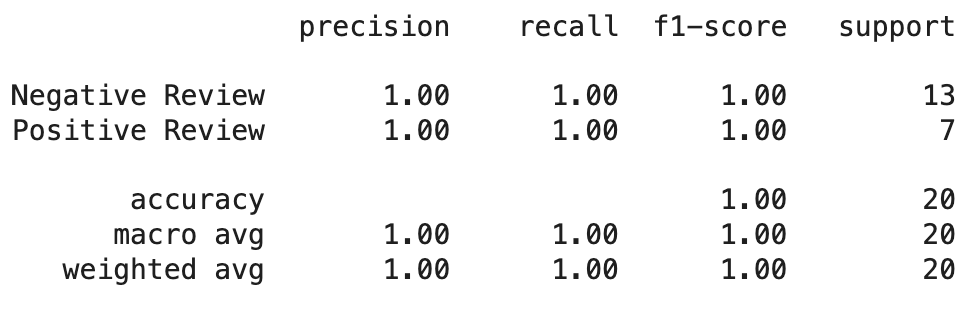


Before you use this over a potentially large dataset, it is important to always keeptrack of your usage. External APIs for closed models can quickly become costly if you perform many requests.

Only run below when you have sufficient fund as this will call the API for the entire test dataset (1066 records).


In [ ]:
# ### Uncomment below, if you want to call APIs for the full test data
# predictions = []
# cnt_errors = 0

# for doc in tqdm(data["test"]["text"]):
#     prediction = chatgpt_generation(prompt, doc, my_model)

#     try:
#         predictions.append(int(prediction)) # check if the results is an integer number
#     except:
#         print("Error:", prediction)
#         cnt_errors += 1
#         predictions.append(1) # if there's an error, append "1" as a default value

# # Extract predictions
# y_pred = [int(pred) for pred in predictions]

# # Evaluate performance
# evaluate_performance_on_testset(y_pred)

### [Optional] ChatGPT for Classification

We can use ChatGPT for classification through OpenAI's API.

Before proceeding with the classification example, you'll need to create a free account on OpenAI and generate an API key here. Once you have your API key, you can use it to interact with OpenAI's servers.


In [ ]:
# Your the API key to create a client

import openai

# Create client
client = openai.OpenAI(api_key="YOUR_KEY_HERE")

In [ ]:
def chatgpt_generation(prompt, document, model="gpt-3.5-turbo-0125"):
    """Generate an output based on a prompt and an input document."""
    messages=[
        {
            "role": "system",
            "content": "You are a helpful assistant."
            },
        {
            "role": "user",
            "content":   prompt.replace("[DOCUMENT]", document)
            }
    ]
    chat_completion = client.chat.completions.create(
      messages=messages,
      model=model,
      temperature=0
    )
    return chat_completion.choices[0].message.content

In [ ]:
# Define a prompt template as a base
prompt = """Predict whether the following document is a positive or negative movie review:

[DOCUMENT]

If it is positive return 1 and if it is negative return 0. Do not give any other answers.
"""

# Predict the target using GPT
document = "unpretentious , charming , quirky , original"
chatgpt_generation(prompt, document)

The next step would be to run one of OpenAI's model against the entire evaluation dataset. However, only run this when you have sufficient tokens as this will call the API for the entire test dataset (1066 records).


In [ ]:
# ### Uncomment below if you'd like to call the API for the entire test dataset
# predictions = [chatgpt_generation(prompt, doc) for doc in tqdm(data["test"]["text"])]

# # Extract predictions
# y_pred = [int(pred) for pred in predictions]

# # Evaluate performance
# evaluate_performance(data["test"]["label"], y_pred)

The performance of GPT-3.5-Turbo-0125 on the test set is as follows (as of September 2025):

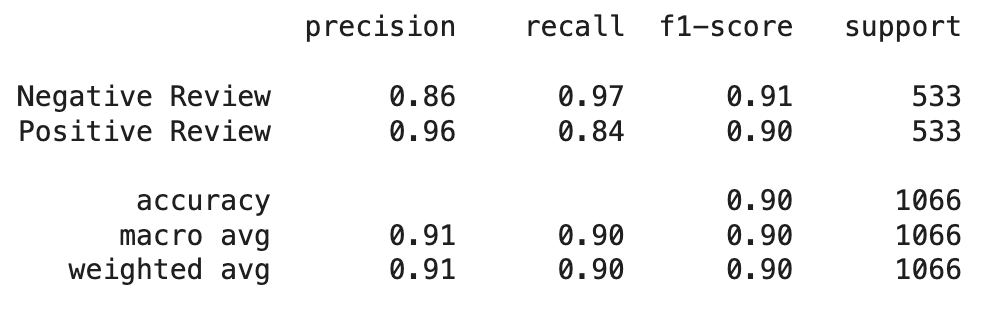

The performance of GPT-3.5-Turbo-0125 on the test set is as follows (as of September 2025):



## Practice 4.  Improving Sentiment Classification

Enhance the sentiment classification performance! You could try he following:

1. Use a Different ML Algorithm: Replace logistic regression with SVM, Random Forest, XGBoost, or a neural network, and compare performance.

2. Experiment with Prompt Engineering: Modify the LLM prompt to see if different wording improves accuracy.

3. Try a Different Task-Specific Model: Swap the current model with some other model for sentiment analysis. You can find models from huggins face.


Can anyone achieve a macro-average F1-score higher than 0.85? (the best baseline: Sentence-BERT + Logistic Regression)